<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Laboratorio: Construcción Modelo de Clasificación y Evaluación de Métricas

Tras realizar el preprocesamiento de los datos y dejarlos listos para construir modelos, ha llegado el momento de dar el siguiente paso: desarrollar tu **primer modelo de clasificación**.

El objetivo de este laboratorio es implementar un modelo de clasificación inicial utilizando **Regresión Logística (Logistic Regression)**. Este modelo te permitirá obtener las primeras predicciones para identificar transacciones normales y anómalas, así como evaluar su desempeño utilizando métricas estándar.

Además, deberás evaluar si el modelo está en riesgo de **overfitting**, asegurando que nuestras predicciones sean consistentes tanto en los datos de entrenamiento como en los de prueba.


## Objetivo del Laboratorio

1. Entrenar un modelo de **Regresión Logística** para predecir si una transacción es "Normal" o "Anómala".

2. Evaluar el desempeño del modelo utilizando métricas como:

   - Precisión (Accuracy).

   - Matriz de confusión.

   - Precisión (Precision), exhaustividad (Recall) y F1-Score.

   - Área bajo la curva ROC (AUC-ROC).

3. Determinar si el modelo presenta **overfitting** o **underfitting**, analizando el rendimiento en los datos de entrenamiento y prueba.


In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

from src.support_logistic import * 

import warnings 
warnings.filterwarnings('ignore')


Cargamos el dataframe a través del pkl.

In [2]:
df = pd.read_pickle("datos/prepped_data.pkl")
df.head()

,is_fraudulent,customer_id,merchant_id,amount,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa
0,0,0.779808,0.510079,0.575423,0.389453,0.900628,0.480769,0.0,0.0,1.0,0.0
1,1,0.791454,0.584829,0.189301,0.578321,0.143774,0.826923,0.0,0.0,0.0,1.0
2,1,0.948651,0.463460,0.123960,1.000000,0.900628,0.750000,0.0,0.0,1.0,0.0
3,1,0.791454,0.541243,0.761671,1.000000,0.512530,0.788462,0.0,1.0,0.0,0.0
4,1,0.518519,0.533525,0.188153,0.389453,0.678115,0.346154,0.0,0.0,1.0,0.0


Vamos a separar la variable respuesta de las predictoras, con un sampling del 70%.

In [3]:
X = df.drop(columns = "is_fraudulent")
y = df["is_fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Ahora vamos a ejecutar un grid search cross validation con los diferentes parámetros que elegimos. Además, pondremos de scoring de f1, ya que es la más equilibrada, y queremos priorizar el minimizado de falsos negativos (FN), ya que es mejor detectar un fraude y que al final no lo sea (FP) a clasificarlo como no fraude y serlo (FN).

También se intentó un scoring de "recall", que sería lo más interesante, ya que se maximiza al minimizar FN, pero prioriza demasiado esta métrica y obtenemos un modelo sin FN, pero porque no hay ningún negativo (son todo 1).

In [4]:
parametros_logistic =  [{'penalty': ['l1'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]},
    {'penalty': ['none'], 'solver': ['lbfgs'], 'max_iter': [10000]}]

regressor = LogisticRegression()

gridsearch = GridSearchCV(estimator = regressor, param_grid=parametros_logistic, cv = 5, scoring = "f1")

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [10000], 'penalty': ['l1'],
                          'solver': ['saga']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [10000], 'penalty': ['l2'],
                          'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'max_iter': [10000], 'penalty': ['elasticnet'],
                          'solver': ['saga']},
                         {'max_iter': [10000], 'penalty': ['none'],
                          'solver': ['lbfgs']}],
             scoring='f1')

Nos quedamos con el mejor modelo tras el CV.

In [5]:
best_regressor = gridsearch.best_estimator_

Ahora predeciremos para el train y el test. Además para este caso también tenemos las probabilidades, que indican qué tan probable es que el valor obtenido corresponda a 1. La elección de los valores finales dependerán del threshold (umbral) que escojamos. Por defecto se escoge 0.5, por lo que si la prob < 0.5 se le asigna 0 y si prob > 0.5 se le asignará 1.

In [6]:
y_train_predict = best_regressor.predict(X = X_train)
y_test_predict = best_regressor.predict(X = X_test)

y_train_predict_prob = best_regressor.predict_proba(X = X_train)[:, 1]
y_test_predict_prob = best_regressor.predict_proba(X = X_test)[:, 1]


Ahora que tenemos los valores predichos, podemos obtener métricas que nos ayuden a comprobar la validez de nuestro modelo. Comencemos obteniendo la matriz de confusión:

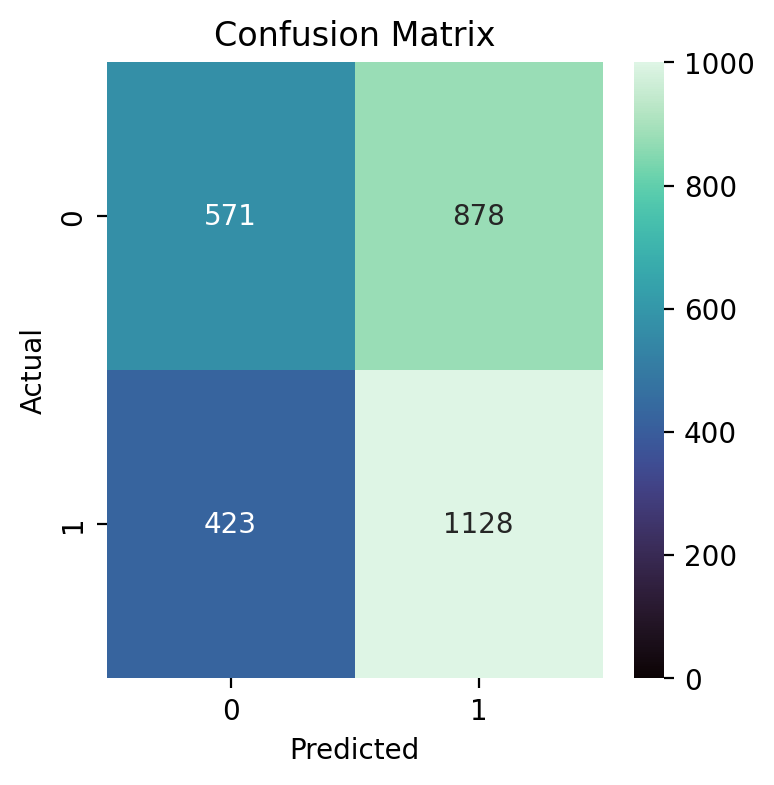

In [7]:
conf_mat = confusion_matrix(y_test, y_test_predict)
plt.figure(figsize = (4,4), dpi = 200)
sns.heatmap(conf_mat, annot=True, fmt="d", vmin=0, vmax=1000, cmap="mako")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Los cuadrantes 2 y 4 indican verdaderos: verdaderos positivos (TP, cuadrante 4) y verdaderos negativos (TN, cuadrante 2). \
Los cuadrantes 1 y 3 indican falsos: falsos positivos (FP, cuadrante 1) y falsos negativos (FN, cuadrante 3).

TP y TN son intuitivos: la predicción coincide con la realidad. \
FP y FN son más confusos: Falso Positivo indica que la predicción dice que una entrada es positiva cuando realmente no lo es, y Falso Negativo indica que la predicción dice que una entrada es negativa cuando realmente es positiva. Para un ejemplo más práctico, visitar este [link](https://www.linkedin.com/posts/yanruwujin_y-si-un-modelo-de-ia-decidiera-qu%C3%A9-mensajes-activity-7267127861440880640-Df_u?utm_source=share&utm_medium=member_desktop).

Calculemos ahora algunas de las métricas, y vamos a explicarlas.

In [8]:
metricas_regresion = metricas_logisticas(y_train, y_train_predict, y_test, y_test_predict, y_train_predict_prob, y_test_predict_prob)
metricas_regresion

,precision,accuracy,recall,f1_score,kappa,auc
train,0.539412,0.550429,0.719932,0.616734,0.099365,0.578959
test,0.562313,0.566333,0.727273,0.634242,0.122604,0.584281


- Precision: Nos indica la proporción de verdaderos positivos sobre el total de positivos predichos (tanto verdaderos como falsos).

$$Precision = \frac{TP}{TP+FP}$$

- Accuracy: Nos indica la proporción de aciertos (positivos y negativos) sobre el total de los datos.

$$Accuracy = \frac{TP+TN}{TP+FN+TN+FP}$$

- Recall: Nos indica la proporción de verdaderos positivos sobre el total de positivos reales, o sea, cuántos positivos hemos interpretado correctamente de la realidad.

$$Recall = \frac{TP}{TP+FN}$$

- f1 score: Es una medida más equilibrada entre Precision y Recall, concretamente una media armónica.

$$f_1 score = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$

- kappa: Es una medida que nos da información sobre qué tan probable es que nuestras predicciones acierten por fruto del azar.

- AUC: Area Under the Curve, nos indica el área debajo de la curva del ROC (Receiver Operating Characteristic). La curva ROC viene dada por los ratios de verdaderos positivos (TPR o recall) y los ratios de falsos positivos (FPR) para un umbral dado, por lo que maximizar TPR y minimizar FPR sería el objetivo de nuestro ejercicio, intentando ajustarse lo máximo posible a esta optimización.


Para calcular el AUC y curva ROC vamos a necesitar los TPR, FPR y umbrales. Los obtenemos con la función de sklearn:

In [9]:
fpr, tpr, thresholds =  roc_curve(y_test, y_test_predict_prob)

Ploteamos:

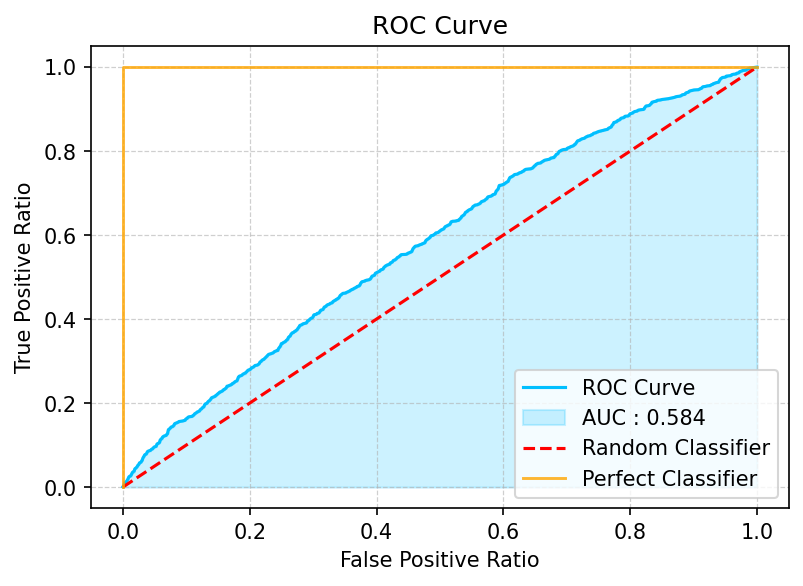

In [10]:
diag = np.linspace(0,1,len(fpr))

plt.figure(figsize=(6,4), dpi = 150)
plt.grid(ls = "--", lw = 0.6, alpha = 0.6)
plt.title("ROC Curve")
sns.lineplot(x = fpr, y = tpr, color = "deepskyblue", label = "ROC Curve")
plt.fill_between(fpr, tpr, color = "deepskyblue", alpha = 0.2, interpolate=False, label = f'AUC : {metricas_regresion.loc["test" ,"auc"]:.3f}')
plt.plot(diag,diag, color = "red", ls = "--", label = "Random Classifier")
plt.plot([0,0,1], [0,1,1], color = "orange", lw = 1.4, alpha = 0.8, label = "Perfect Classifier")
plt.xlabel("False Positive Ratio")
plt.ylabel("True Positive Ratio")
plt.legend()
plt.show()

Vemos que nuestra curva no es la más óptima, y esto se ve con la proximidad de esta a la recta de clasificador aleatorio, que indicaría que las predicciones son fruto del azar; y la lejanía a la del clasificador perfecto.

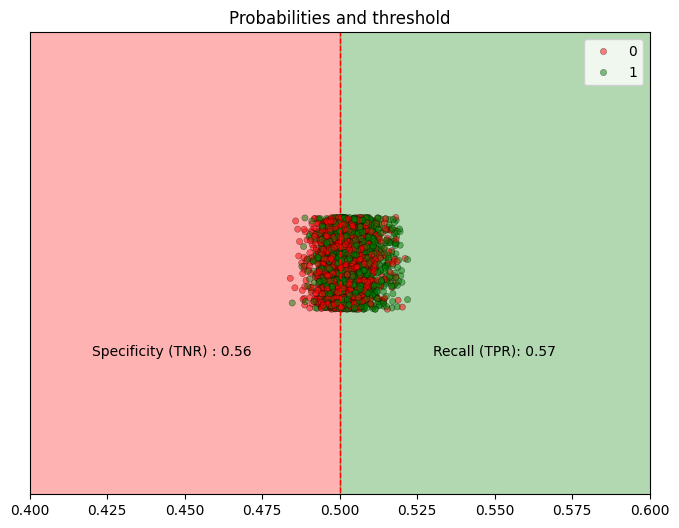

In [11]:
threshold = 0.5
tn = (y_test.iloc[np.where(y_test_predict_prob<=threshold)[0]] == 0).sum()
tp = (y_test.iloc[np.where(y_test_predict_prob>=threshold)[0]] == 1).sum()
all_p = (y_test_predict_prob >= threshold).sum()
all_n = (y_test_predict_prob <= threshold).sum()


plt.figure(dpi = 100, figsize = (8,6))

plt.title("Probabilities and threshold")
plt.fill_between(x = [0,threshold], y1 = 1, y2 = -1, alpha = 0.3, color = "red")
plt.fill_between(x = [threshold, 1], y1 = 1, y2 = -1, alpha = 0.3, color = "green")
plt.vlines(x = threshold, ymin = -1, ymax = 1, ls = "--", color = "red", lw = 1)
sns.scatterplot(
    x=y_test_predict_prob, 
    y=np.zeros_like(y_test_predict_prob) + np.random.uniform(-0.1, 0.1, len(y_test_predict_prob)), 
    hue=y_test,  
    alpha=0.5, 
    s=20, 
    edgecolor="black",
    palette = ["red", "green"]
)
plt.annotate(f"Recall (TPR): {tn/all_n:.2f}", xy = [0.575, 0], xytext = [0.53,-0.2])
plt.annotate(f"Specificity (TNR) : {tp/all_p:.2f}", xy = [0.425, 0], xytext = [0.42,-0.2])
plt.legend()

plt.yticks(ticks=[])
plt.ylim(-0.5,0.5)
plt.xlim(0.4, 0.6)
plt.show()

Esta es otra de las visualizaciones, donde los puntos son cada uno de los registros y su probabilidad, con su color representando el valor real, y el color de cada cuadrante indica el valor que se predice con el modelo dado un umbral. Cuanto mayor el umbral, mayor es la cantidad de negativos, aumentando los FN y TN, lo cual disminuye el recall, y cuanto menor el umbral, mayor la cantidad de positivos, aumentando FP y TP, lo cual disminuye la especificidad (TNR).

Se puede ver mejor con una gráfica interactiva.

In [12]:
plot_interactive_probs(y_test, y_test_predict_prob)

Especificidad es el TNR:
$$Specifity = \frac{TN}{TN+FP}$$

Equivalente al recall pero con los negativos.

Con la gráfica interactiva podemos ver los efectos de la elección del threshold en nuestras métricas, algo que visualizamos de forma general con la curva ROC.

